# 🚢 **Titanic prediction with bagging technique** 
---------------------------------------

# 📚 Import Libraries

In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 📂 Initial settup

In [121]:
# import the datasets
train = pd.read_csv('train.csv')
x_test = pd.read_csv('test.csv')
y_test = pd.read_csv('gender_submission.csv')

In [122]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [123]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 🛀 Data cleaning

### Removing null values

In [124]:
null = train.isnull().sum().reset_index()
null['Percent'] = (null[0] / len(train)) * 100
null.columns=['Variables','Number','Percent']
null.sort_values(by='Percent',ascending=False).head(3)

,Variables,Number,Percent
10,Cabin,687,77.104377
5,Age,177,19.865320
11,Embarked,2,0.224467


As we can see, there are 3 features that has missing values
and cabin being the one with the most null values

<Axes: >

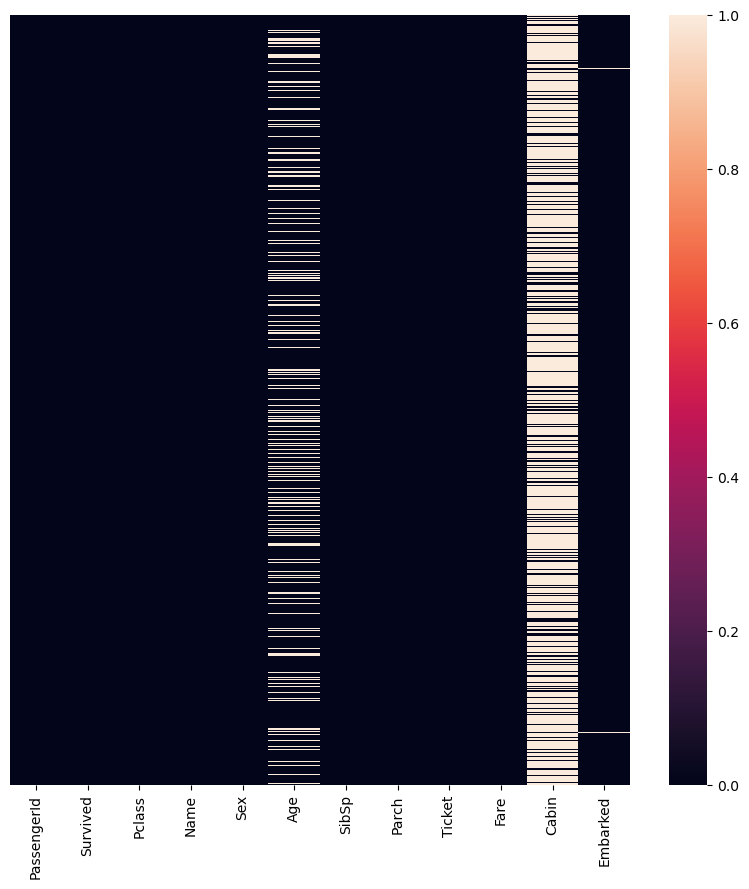

In [125]:
#lets see how the null values are distributed
plt.figure(figsize=(10,10))
sns.heatmap(train.isnull(),yticklabels=False,cbar=True)

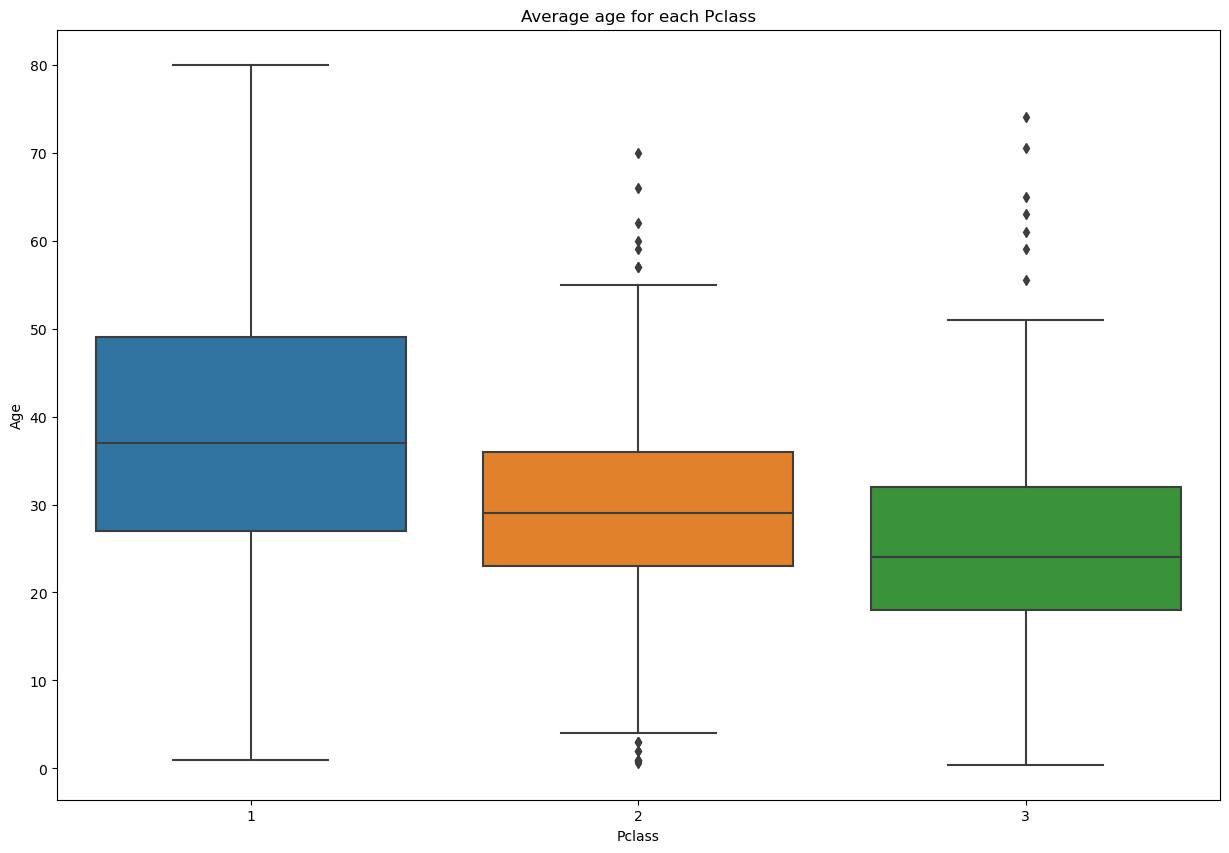

In [126]:
# as we can see, the age feature, although it has a lot of nulls, we can say that
# there is room for improvement, lets see the connection between age and Pclass
plt.figure(figsize=(15,10))
plt.title("Average age for each Pclass")
sns.boxplot(data=train, x='Pclass',y='Age')
plt.show()

In [127]:
# average in numbers
train.groupby('Pclass')['Age'].mean().reset_index()

,Pclass,Age
0,1,38.233441
1,2,29.877630
2,3,25.140620


### How this data can help us ?
well as we see, the average age for Pclass 1 is around 38 years old
and for other class its 29 and 23 respectively. so if we can replace them with 
i mean sure we can use the average, but using the average of each respective group would 
be so much better

In [128]:
# make the if function to determine age from pclass
def age_1(column):
    age = column[0]
    pclass = column[1]
    
    if pd.isnull(age):
        if pclass==1:
            return 38.233
        elif pclass==2:
            return 29.877
        else : 
            return 25.140
    else : 
        return age

In [129]:
# run the if function
train['Age'] = train[['Age','Pclass']].apply(age_1,axis=1)

In [130]:
# Lets drop rows that isnt used for training 
train.drop(['PassengerId','Ticket','Cabin','Name'],inplace=True,axis=1)
x_test.drop(['PassengerId','Ticket','Cabin','Name'],inplace=True,axis=1)

In [131]:
# the embarked features only has 2 missing valies so dropping it wont make 
# much of a difference
train = train.dropna(axis=0,how='any')

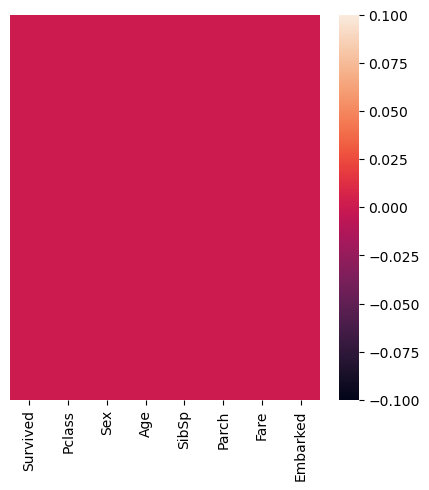

In [132]:
# lets see if our table contain any null values now
plt.figure(figsize=(5,5))
sns.heatmap(train.isnull(),yticklabels=False,cbar=True)
plt.show()

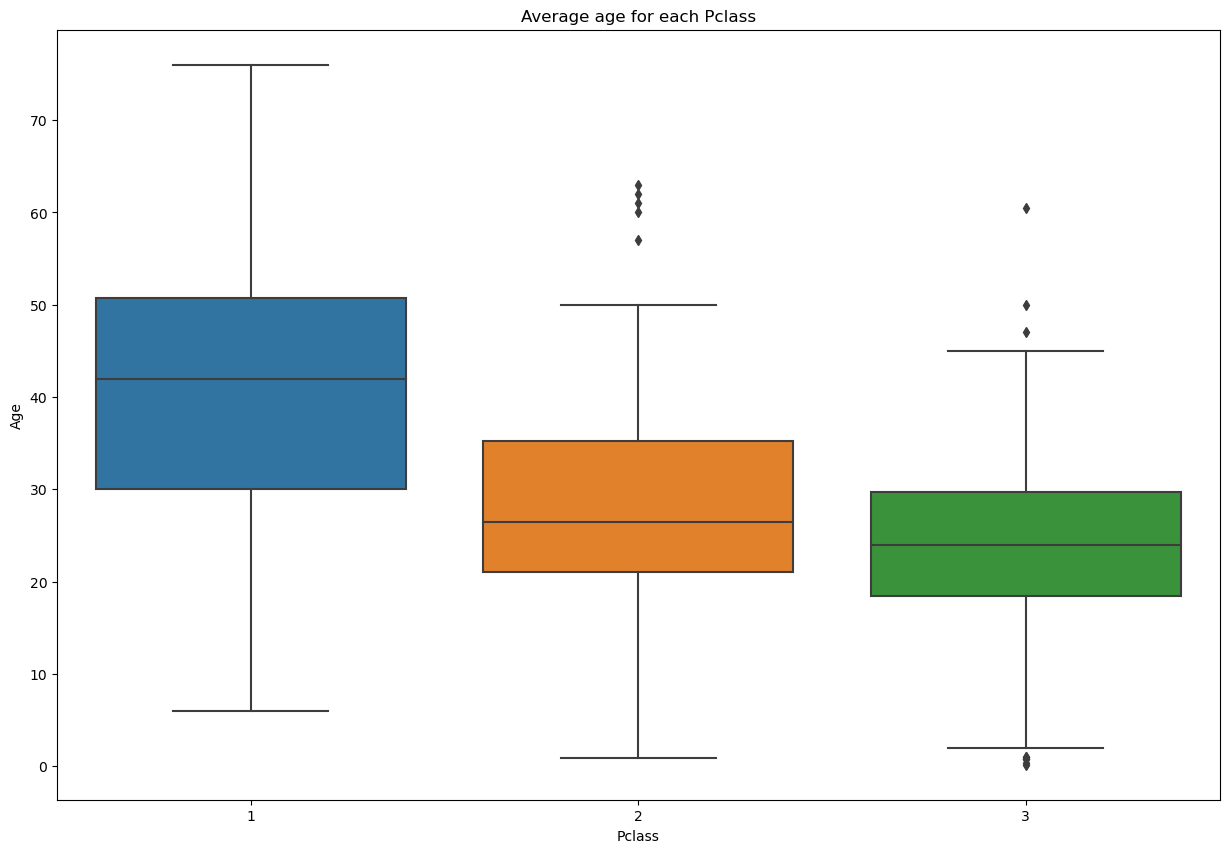

In [133]:
plt.figure(figsize=(15,10))
plt.title("Average age for each Pclass")
sns.boxplot(data=x_test, x='Pclass',y='Age')
plt.show()

In [134]:
def age_1(cols) :
    Age=cols[0]
    Pclass=cols[1] 
    
    if pd.isnull(Age) :
        if Pclass==1 :
            return 42 
        elif Pclass==2:
            return 25
        else :
            return 22
    else :
        return Age

In [135]:
x_test['Age'] = x_test[['Age','Pclass']].apply(age_1,axis=1)

# 📊 Data visualization

<Axes: xlabel='Survived', ylabel='count'>

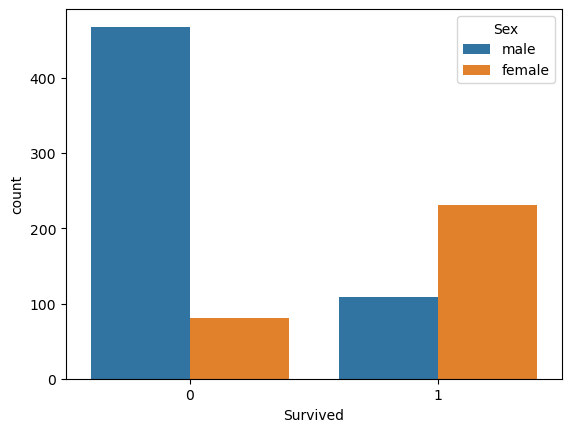

In [136]:
# lets see the survival rate by gender
sns.countplot(data=train,x='Survived',hue='Sex')

In [137]:
# survival rate by gender and age
train.groupby(['Survived','Sex'])['Age'].mean()

Survived  Sex   
0         female    25.066420
          male      30.641596
1         female    28.637883
          male      27.649991
Name: Age, dtype: float64

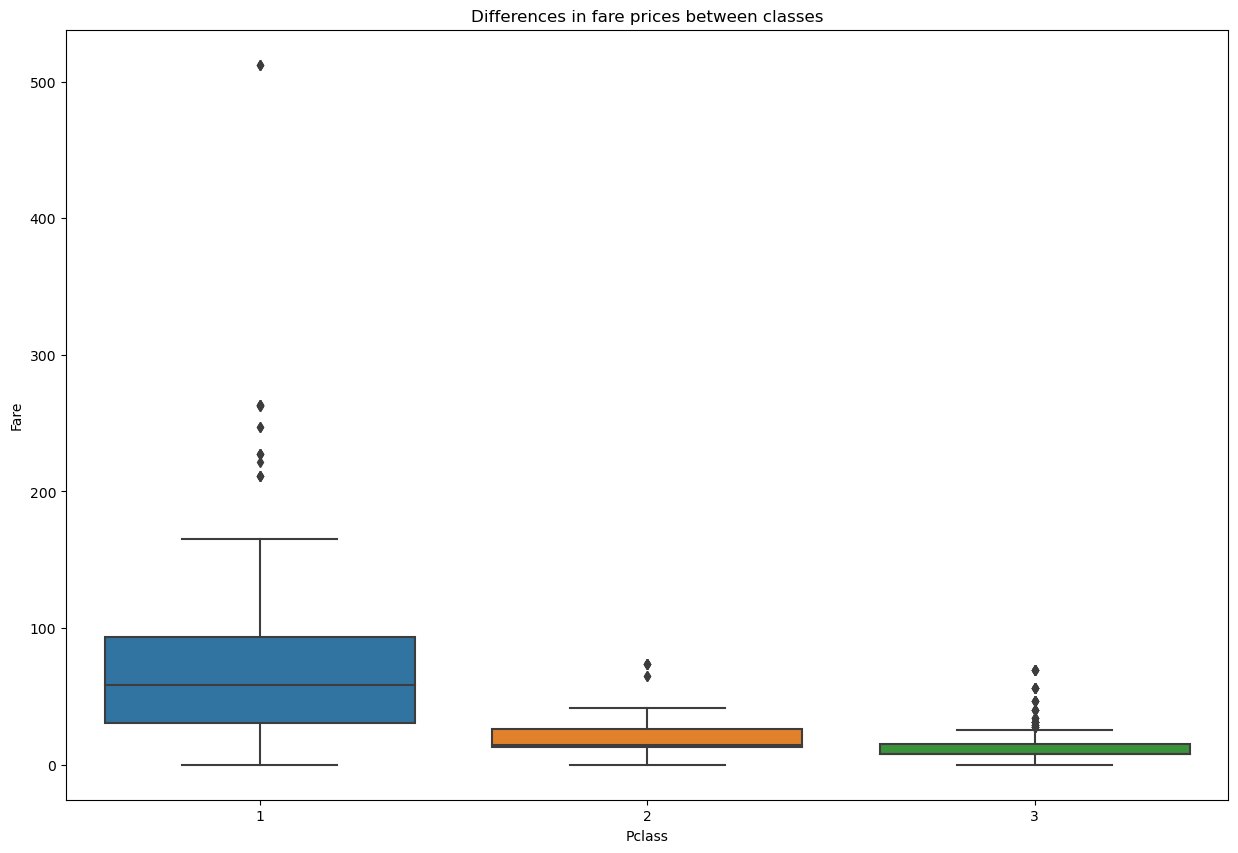

In [138]:
plt.figure(figsize=(15,10))
sns.boxplot(data=train, x='Pclass', y='Fare')
plt.title('Differences in fare prices between classes')
plt.show()

### Chart interpretation :
- Pclass 1 is significantly more expensive then the other classes
- Pclass 1 and 3 had more outliers then Pclass 2

**this means there is a lot of noise in the data, something we must take care of
to reduce the probability of overfitting**

<Axes: xlabel='Survived', ylabel='count'>

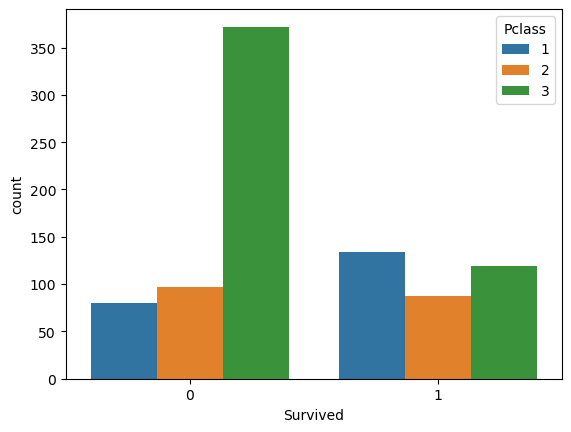

In [139]:
sns.countplot(data=train, x='Survived',hue='Pclass')

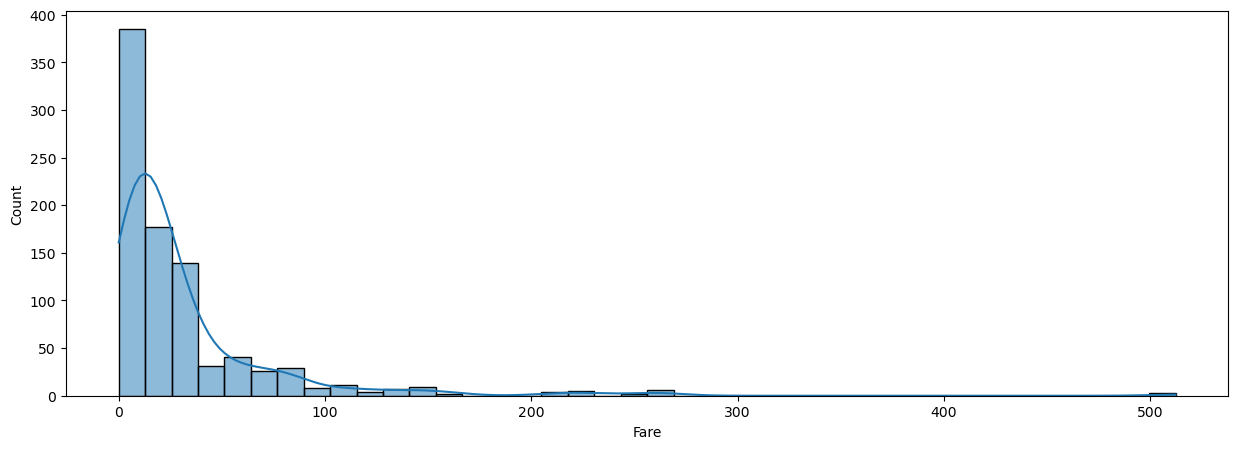

In [140]:
plt.figure(figsize=(15,5))
sns.histplot(train['Fare'], bins=40, kde=True)
plt.show()

C:\Users\Glenn Artistro Yadi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


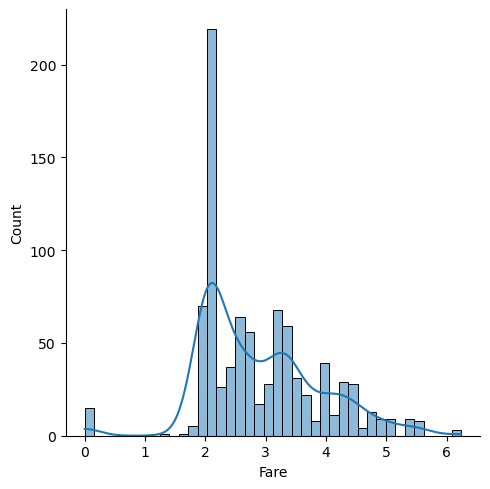

In [141]:
# lets use logratihmic function to make the Fare feature more evenly distributed
train_fare = train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
sns.displot(train_fare, bins=40, kde=True)
plt.show()

### Lets make the dataset for machine learning

In [142]:
# lets apply the logarithmic function to fare
fare=train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

In [143]:
# lets turn the categorical variable into numbers using get_dummies method
sex=pd.get_dummies(train['Sex'],drop_first=True).astype(int)
embarked=pd.get_dummies(train['Embarked'],drop_first=True).astype(int)

### Why Use `drop_first=True` in `pd.get_dummies()`

When creating dummy variables for a categorical feature with `n` categories:

1. **Avoid Redundancy**: Including all `n` dummy variables creates redundancy because one category can be perfectly predicted from the others. This results in perfect multicollinearity, which causes problems in regression models.

2. **Implicit Representation**: Dropping the first category creates a baseline. The dropped category is implicitly represented by the absence of other dummy variables. For example, if 'Embarked_C' is dropped, then if both 'Embarked_Q' and 'Embarked_S' are 0, it implies the observation belongs to category 'C'.

3. **Retain All Information**: Even after dropping one dummy variable, no information is lost. The dropped category is inferred from the remaining variables.


4. **Mathematical Necessity**: Dropping one dummy variable prevents multicollinearity, ensuring that the model matrix is invertible and the regression coefficients can be calculated correctly.

By using `drop_first=True`, we simplify the model and avoid these issues.


In [144]:
# Drop uneeded data 
y_train = train['Survived']
train.drop(['Embarked','Sex','Survived','Fare'], inplace=True, axis=1)

In [145]:
x_train = pd.concat([train,sex,embarked,fare],axis=1)
y_test.drop('PassengerId',inplace=True, axis=1) 

In [146]:
x_train

,Pclass,Age,SibSp,Parch,male,Q,S,Fare
0,3,22.00,1,0,1,0,1,1.981001
1,1,38.00,1,0,0,0,0,4.266662
2,3,26.00,0,0,0,0,1,2.070022
3,1,35.00,1,0,0,0,1,3.972177
4,3,35.00,0,0,1,0,1,2.085672
...,...,...,...,...,...,...,...,...
886,2,27.00,0,0,1,0,1,2.564949
887,1,19.00,0,0,0,0,1,3.401197
888,3,25.14,1,2,0,0,1,3.154870
889,1,26.00,0,0,1,0,0,3.401197


# 🤖 Machine learning using logistic regression

# 🤖 Machine learning using bagging technique

# Thanks for reading this notebook !